In [2]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
from io import StringIO
import altair as alt
from altair import datum
import arviz as az
from scipy.stats import gaussian_kde

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## functions to read in trees files and extract migration jumps

In [3]:
def get_taxa_lines(tree_path):    
    # write out a temp tree file
#     temp_tree = tree_path.replace(".trees",".temp.tree")
#     with open(temp_tree, "w") as outfile: 
#         outfile.write("")

    lines_to_write = ""
    with open(trees, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [4]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [5]:
#making decimal date from string dates adapted from stackoverflow (thank you coding geniuses)
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [225]:
def enumerate_migration_events(tree, traitType):
        
    output_dict = {}
    migration_events_counter = 0
        
    for k in tree.Objects:
        trait = k.traits[traitType]
        parent_node = k.parent
        
        if traitType not in parent_node.traits:
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
        else:
            parent_trait = parent_node.traits[traitType]
        
        if trait != parent_trait:
            migration_events_counter += 1

            migration_event = parent_trait + "-to-" + trait
            #migration_date = parent_node.absoluteTime                

            # write to output dictionary
            output_dict[migration_events_counter] = {"type":migration_event, #"date":migration_date,
                                                    "parent_host":parent_trait,
                                                    "child_host": trait, "tree_length": sum([x.length for x in tree.Objects])}

    return(output_dict)

In [116]:
#counts all migration events and records parent and child nodes
def run_mig_counts(all_trees, traitType):
    start_time = time.time()
    with open(all_trees, "r") as infile:

        tree_counter = 0
        trees_processed = 0
        migrations_dict = {}

        for line in infile:
            if 'tree STATE_' in line:
                tree_counter += 1

                if tree_counter > burnin:
                    temp_tree = StringIO(taxa_lines + line)
                    tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                    tree.setAbsoluteTime(2023.0068)
                    trees_processed += 1

                    # iterate through the tree and pull out all migration events
                    migrations_dict[tree_counter] = enumerate_migration_events(tree, traitType)

    # print the amount of time this took
    total_time_seconds = time.time() - start_time
    total_time_minutes = total_time_seconds/60
    print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
   
    """this will generate a multi-index dataframe from the migrations dictionary"""
    migrations_df = pd.DataFrame.from_dict({(i,j): migrations_dict[i][j] 
                           for i in migrations_dict.keys() 
                           for j in migrations_dict[i].keys()},
                       orient='index')

    migrations_df.reset_index(inplace=True)
    migrations_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
    
    return(migrations_df)

### work on presistence times

In [8]:
#need to convert the decimal dates back to calendar dates 
def convert_persistence(number):

    
    d = timedelta(days=(number)*(365))
    
    return d.total_seconds()

In [41]:
#this is adapted from Bedford et al in nature where we start at a time and then walk backwards up the tree until the location changes
def estimate_persistence(tree, typeTrait):
        
    output_dict = {}
    persistence_counter = 0
        
    for k in tree.Objects:
        
        
        trait = k.traits[typeTrait]
        parent_node = k.parent
        if ('root' in parent_node.traits) or (parent_node.traits == {}) :
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
        elif k.branchType=='leaf':
            tip_date= k.absoluteTime
            tip_name = k.name
            confirm = True
            while confirm == True:
                try:
                    parent_trait = parent_node.traits[typeTrait]
                    
                    if trait != parent_trait:
                        persistence_counter += 1

                        migration_event = parent_trait + "-to-" + trait
                        migration_date = parent_node.absoluteTime
                        
                        persistence =  tip_date - migration_date

    
                        # write to output dictionary
                        output_dict[persistence_counter] = {"type":migration_event, "migration date":migration_date,"tip date": tip_date, "persistance": persistence, "tip_name" : tip_name,
                                                        "parent_host":parent_trait,
                                                        "child_host": trait}
                        confirm = False
                    else:    
                        parent_node = parent_node.parent    

                except:
                    break
                    

        else:
            continue
    
    return(output_dict)

## now regional

In [490]:
trees =  "../dta/results/main/ds_skygrid_1000.trees"

In [492]:
all_trees = trees
burnin_percent = 0.2
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

412.8


In [493]:
migrations_df = run_mig_counts(all_trees, traitType = "region")

412.8
this took 296.5469880104065 seconds ( 4.942449800173441  minutes) to run on 1652 trees


In [494]:
migrations_df.migration_event_number.describe()

count    101387.000000
mean         31.548147
std          18.331824
min           1.000000
25%          16.000000
50%          31.000000
75%          47.000000
max          84.000000
Name: migration_event_number, dtype: float64

In [495]:
foo = migrations_df.tree_number.value_counts().reset_index().rename(columns = {"index":"tree", "tree_number": "mig_count"}) ;foo

,tree,mig_count
0,668,84
1,1457,82
2,727,81
3,1647,78
4,2043,78
...,...,...
1647,431,45
1648,439,45
1649,433,44
1650,435,44


In [496]:
foo["tree_length"] = 0;


In [497]:
migrations_df.index = migrations_df.tree_number; migrations_df

,tree_number,migration_event_number,type,parent_host,child_host,tree_length
tree_number,,,,,,
413,413,1,root-to-WesternEurope,root,WesternEurope,88.235830
413,413,2,WesternEurope-to-SouthernEurope,WesternEurope,SouthernEurope,88.235830
413,413,3,SouthernEurope-to-NorthAmerica,SouthernEurope,NorthAmerica,88.235830
413,413,4,WesternEurope-to-SouthernEurope,WesternEurope,SouthernEurope,88.235830
413,413,5,WesternEurope-to-SouthernEurope,WesternEurope,SouthernEurope,88.235830
...,...,...,...,...,...,...
2064,2064,62,WesternEurope-to-NorthAmerica,WesternEurope,NorthAmerica,84.914241
2064,2064,63,WesternEurope-to-NorthAmerica,WesternEurope,NorthAmerica,84.914241
2064,2064,64,NorthAmerica-to-SouthAmerica,NorthAmerica,SouthAmerica,84.914241


In [498]:
migrations_df.iloc[3097,5]

85.94149634555079

In [499]:
foo.tree_length = migrations_df.iloc[foo.tree, 5].values[1] ; foo

,tree,mig_count,tree_length
0,668,84,83.395167
1,1457,82,83.395167
2,727,81,83.395167
3,1647,78,83.395167
4,2043,78,83.395167
...,...,...,...
1647,431,45,83.395167
1648,439,45,83.395167
1649,433,44,83.395167
1650,435,44,83.395167


In [500]:
for index, row in foo.iterrows():
    foo.iloc[index, 2] = migrations_df.iloc[int(row.tree),5]

In [501]:
foo["weighted_count"] = foo.mig_count/foo.tree_length ; foo

,tree,mig_count,tree_length,weighted_count
0,668,84,84.364070,0.995685
1,1457,82,83.395167,0.983270
2,727,81,85.799162,0.944065
3,1647,78,86.525299,0.901470
4,2043,78,85.782689,0.909274
...,...,...,...,...
1647,431,45,86.235319,0.521828
1648,439,45,86.235319,0.521828
1649,433,44,86.235319,0.510232
1650,435,44,86.235319,0.510232


In [502]:
foo.weighted_count.mean()

0.7203858806134146

In [503]:
az.hdi(foo.weighted_count.astype(float).to_numpy(), 0.95)

array([0.57853977, 0.87430228])

In [419]:
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()

imports.index = imports.child_host
exports.index = exports.parent_host

#mig_dict = {}
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

ValueError: 'tree_number' is both an index level and a column label, which is ambiguous.

In [ ]:

colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

In [32]:
start_time = time.time()

with open(trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    persistence_dict = {}
    
    for line in infile:
       # print(line)
        if 'tree STATE_' in line:
            tree_counter += 1
            

            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                tree.setAbsoluteTime(2023.0068)
                trees_processed += 1

            # iterate through the tree and pull out all migration events
                persistence_dict[tree_counter] =  estimate_persistence(tree, "region")
            
# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
persistence_df = pd.DataFrame.from_dict({(i,j): persistence_dict[i][j] 
                           for i in persistence_dict.keys() 
                           for j in persistence_dict[i].keys()},
                       orient='index')

persistence_df
persistence_df.reset_index(inplace=True)
persistence_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
persistence_df.head(5)

this took 334.70945405960083 seconds ( 5.578490900993347  minutes) to run on 1500 trees


,tree_number,migration_event_number,type,migration date,tip date,persistance,tip_name,parent_host,child_host
0,1501,1,WesternEurope-to-SouthernEurope,2022.276664,2022.368444,0.091780,Monkeypox/PT0010/2022_SouthernEurope_2022-05-15,WesternEurope,SouthernEurope
1,1501,2,WesternEurope-to-SouthernEurope,2022.276664,2022.401321,0.124657,Monkeypox/PT0341/2022_SouthernEurope_2022-05-27,WesternEurope,SouthernEurope
2,1501,3,WesternEurope-to-SouthernEurope,2022.276664,2022.390362,0.113698,Monkeypox/PT0354/2022_SouthernEurope_2022-05-23,WesternEurope,SouthernEurope
3,1501,4,WesternEurope-to-SouthernEurope,2022.276664,2022.486252,0.209588,Monkeypox/PT0196/2022_SouthernEurope_2022-06-27,WesternEurope,SouthernEurope
4,1501,5,WesternEurope-to-SouthernEurope,2022.276664,2022.376663,0.099999,Monkeypox/PT0026/2022_SouthernEurope_2022-05-18,WesternEurope,SouthernEurope


In [33]:
persist = persistence_df.groupby(["child_host", "tree_number"])['persistance'].mean().reset_index()
persist['persistance'] = persist['persistance'].map(convert_persistence)
persist['persistance'] = persist['persistance'].div(86400) #calculating number of days from seconds
persist.index = persist.child_host


persist_dict={x:[] for x in persist["child_host"].unique()}

for items in persist.index.unique():
    persist_dict[items].append(persist.loc[items,"persistance"].values)
    


CentralEurope 1.0
CentralEurope 1.0
CentralEurope 1.0
NorthAmerica 10.0
NorthAmerica 11.0
NorthAmerica 13.0
SouthAmerica 4.0
SouthAmerica 4.0
SouthAmerica 5.0
SouthernEurope 3.0
SouthernEurope 5.0
SouthernEurope 7.0
WesternEurope 82.0
WesternEurope 85.0
WesternEurope 90.0
CentralEurope 59.378321977323495
CentralEurope 62.54536020519676
CentralEurope 66.62550365463252
NorthAmerica 99.90670279114583
NorthAmerica 104.65645638838541
NorthAmerica 109.23017498862558
SouthAmerica 99.9022440931684
SouthAmerica 103.51970143060186
SouthAmerica 107.13592991149017
SouthernEurope 66.0594533816985
SouthernEurope 69.72898666532987
SouthernEurope 73.6443429158941
WesternEurope 31.816371166912617
WesternEurope 36.3426215437963
WesternEurope 42.98117868000868


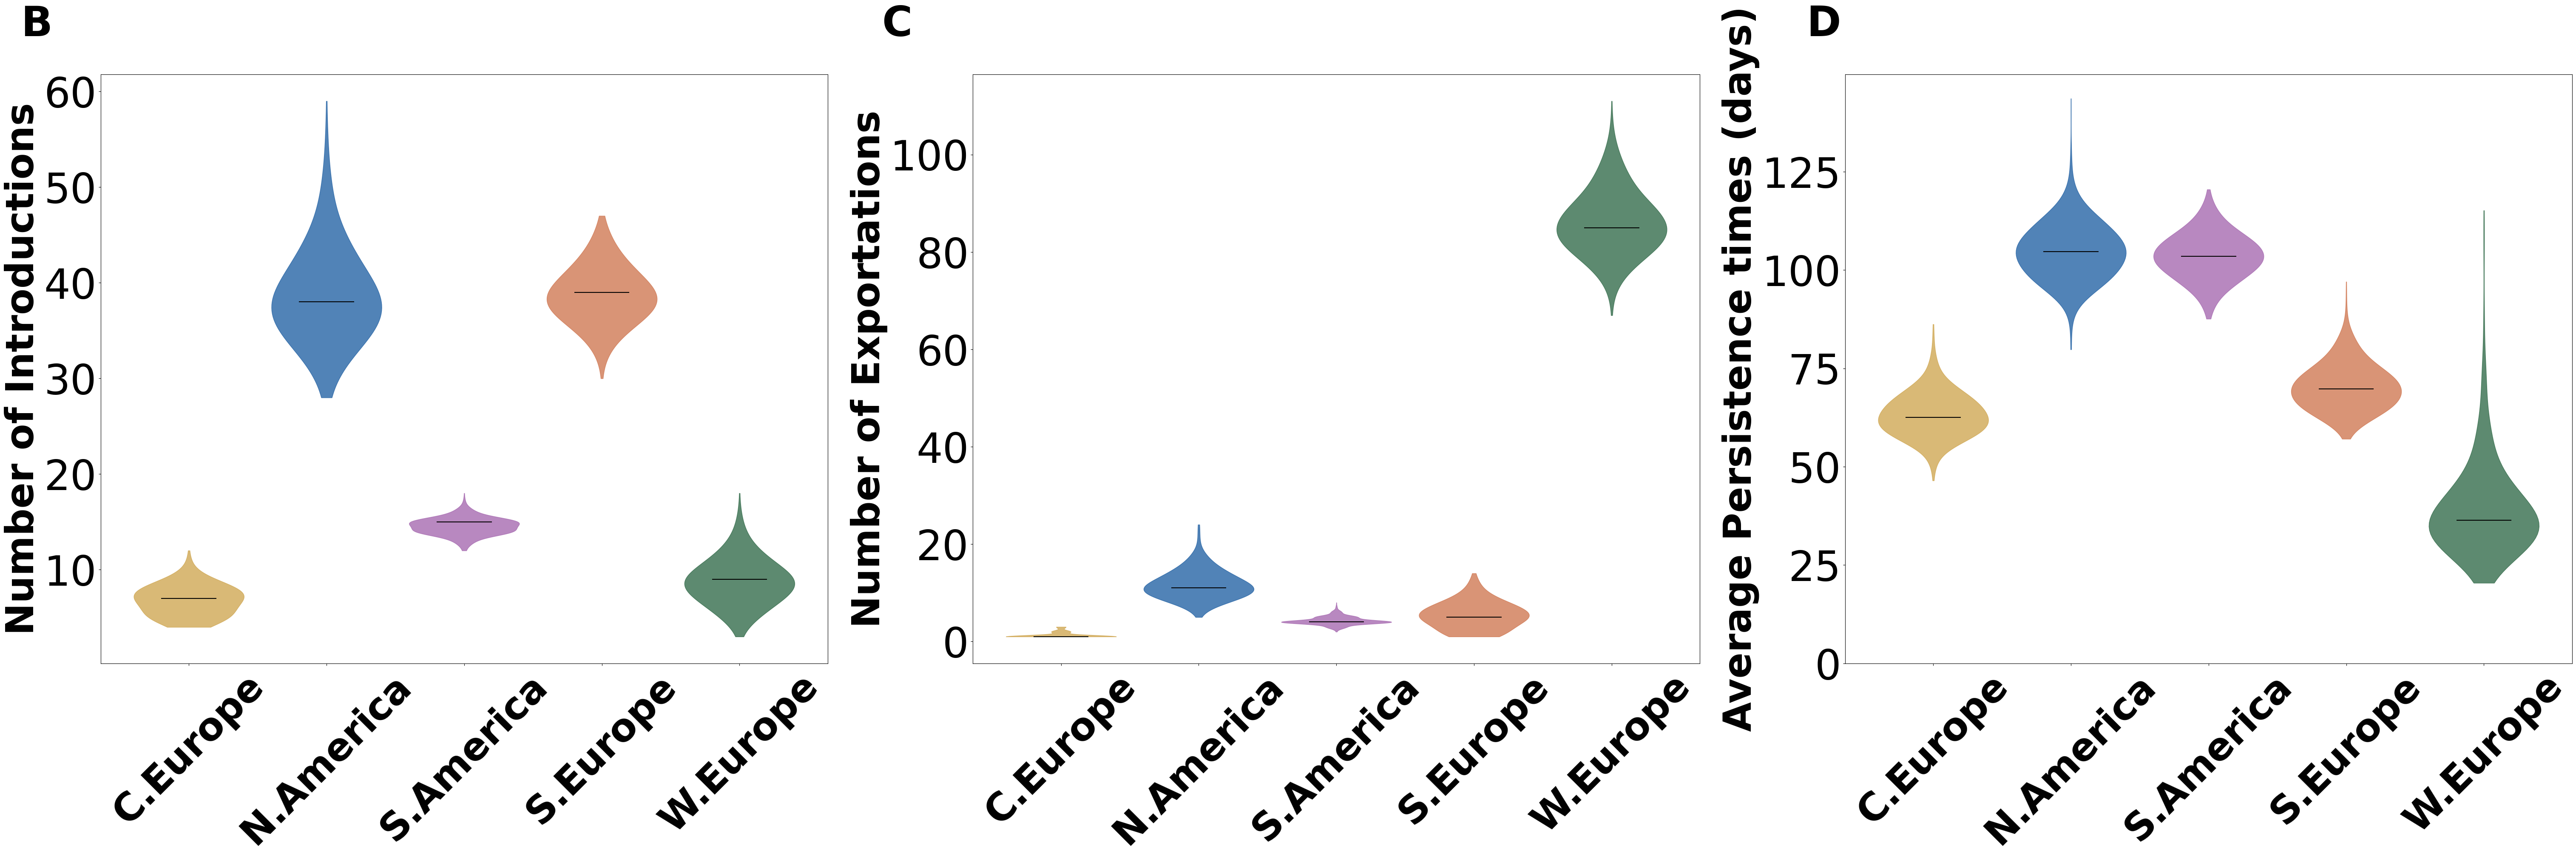

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(75, 18), facecolor='w')
#fig.suptitle('Publication Style Lettering', fontsize=30, fontweight='bold', x=0.05, y=1.05)
region_list = ["N.America", "S.America", "S.Europe", "W.Europe"]

# First plot
pos = []
for index, place in enumerate(mig_dict_imports.keys()):


    violin_plot = axs[0].violinplot(mig_dict_imports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.6, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_imports.keys())
axs[0].set_xticks(pos)
axs[0].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[0].set_ylabel("Number of Introductions", fontsize=65, fontweight='bold')
axs[0].tick_params(axis='y', labelsize=70)

# Second plot
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    print(place, np.quantile(mig_dict_exports[place], 0.25))
    print( place, np.quantile(mig_dict_exports[place], 0.5))
    print(place, np.quantile(mig_dict_exports[place], 0.75))
    violin_plot = axs[1].violinplot(mig_dict_exports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_exports.keys())
axs[1].set_xticks(pos)
axs[1].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[1].set_ylabel("Number of Exportations", fontsize=65, fontweight='bold')
axs[1].tick_params(axis='y', labelsize=70)

# Third plot
pos = []
for index, place in enumerate(persist_dict.keys()):
    print(place, np.quantile(persist_dict[place], 0.25))
    print(place, np.quantile(persist_dict[place], 0.5))
    print(place, np.quantile(persist_dict[place], 0.75))
    violin_plot = axs[2].violinplot(persist_dict[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

countries = list(persist_dict.keys())
axs[2].set_xticks(pos)
axs[2].set_xticklabels(region_list, fontsize=65,rotation=45, fontweight='bold')
axs[2].set_ylabel("Average Persistence times (days)", fontsize=65, fontweight='bold')
axs[2].tick_params(axis='y', labelsize=70)
axs[2].set_ylim(bottom=0)


# Add publication style lettering in the upper left corner
fig.text(0.1, 0.93, "B", fontsize=70, fontweight='bold')
fig.text(0.37, 0.93, "C", fontsize=70, fontweight='bold')
fig.text(0.66, 0.93, "D", fontsize=70, fontweight='bold')

plt.savefig('../figures/1000_dta_region_combined.png', dpi=300, bbox_inches='tight')
plt.show()


# subsampling sensitivity analysis 

In [195]:
trees =  "/Users/mparedes/Desktop/mpox_rhino/dta_equal_temp_downsampled.trees"

In [196]:
all_trees = trees
burnin_percent = 0.0
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

0.0


In [197]:
migrations_df = run_mig_counts(all_trees, traitType = "region")

0.0
this took 501.95284819602966 seconds ( 8.365880803267162  minutes) to run on 3000 trees


In [41]:
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()

imports.index = imports.child_host
exports.index = exports.parent_host

#mig_dict = {}
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

In [42]:

colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

In [43]:
start_time = time.time()

with open(trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    persistence_dict = {}
    
    for line in infile:
       # print(line)
        if 'tree STATE_' in line:
            tree_counter += 1
            

            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                tree.setAbsoluteTime(2023.0068)
                trees_processed += 1

            # iterate through the tree and pull out all migration events
                persistence_dict[tree_counter] =  estimate_persistence(tree, "region")
            
# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
persistence_df = pd.DataFrame.from_dict({(i,j): persistence_dict[i][j] 
                           for i in persistence_dict.keys() 
                           for j in persistence_dict[i].keys()},
                       orient='index')

persistence_df
persistence_df.reset_index(inplace=True)
persistence_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
persistence_df.head(5)

this took 153.6351079940796 seconds ( 2.56058513323466  minutes) to run on 937 trees


,tree_number,migration_event_number,type,migration date,tip date,persistance,tip_name,parent_host,child_host
0,938,1,WesternEurope-to-SouthernEurope,2022.535573,2022.623238,0.087665,Monkeypox/PT0501/2022_SouthernEurope_2022-08-16,WesternEurope,SouthernEurope
1,938,2,WesternEurope-to-NorthAmerica,2022.452883,2022.604060,0.151177,MPX/Human/USA/CA-LACPHL-MA00137/2022_NorthAmer...,WesternEurope,NorthAmerica
2,938,3,WesternEurope-to-NorthAmerica,2022.452883,2022.497211,0.044328,MPXV_USA_2022_CT0002_NorthAmerica_2022-07-01,WesternEurope,NorthAmerica
3,938,4,WesternEurope-to-SouthernEurope,2022.441973,2022.508170,0.066196,Monkeypox/PT0161/2022_SouthernEurope_2022-07-05,WesternEurope,SouthernEurope
4,938,5,WesternEurope-to-NorthAmerica,2022.413993,2022.546526,0.132533,MPX/Human/USA/CA-LACPHL-MA00192/2022_NorthAmer...,WesternEurope,NorthAmerica


In [44]:
persist = persistence_df.groupby(["child_host", "tree_number"])['persistance'].mean().reset_index()
persist['persistance'] = persist['persistance'].map(convert_persistence)
persist['persistance'] = persist['persistance'].div(86400) #calculating number of days from seconds
persist.index = persist.child_host


persist_dict={x:[] for x in persist["child_host"].unique()}

for items in persist.index.unique():
    persist_dict[items].append(persist.loc[items,"persistance"].values)
    


NorthAmerica 10.0
NorthAmerica 11.0
NorthAmerica 13.0
SouthAmerica 2.0
SouthAmerica 2.0
SouthAmerica 2.0
SouthernEurope 1.0
SouthernEurope 2.0
SouthernEurope 3.0
WesternEurope 48.0
WesternEurope 53.0
WesternEurope 58.0
NorthAmerica 115.0918865956713
NorthAmerica 117.82818947476852
NorthAmerica 121.04374966341435
SouthAmerica 99.84638893925926
SouthAmerica 103.3754734930324
SouthAmerica 106.71101455856481
SouthernEurope 58.010510196296295
SouthernEurope 61.29234966831019
SouthernEurope 66.23560505101852
WesternEurope 23.996254762974537
WesternEurope 28.03716553597222
WesternEurope 34.70013151266203


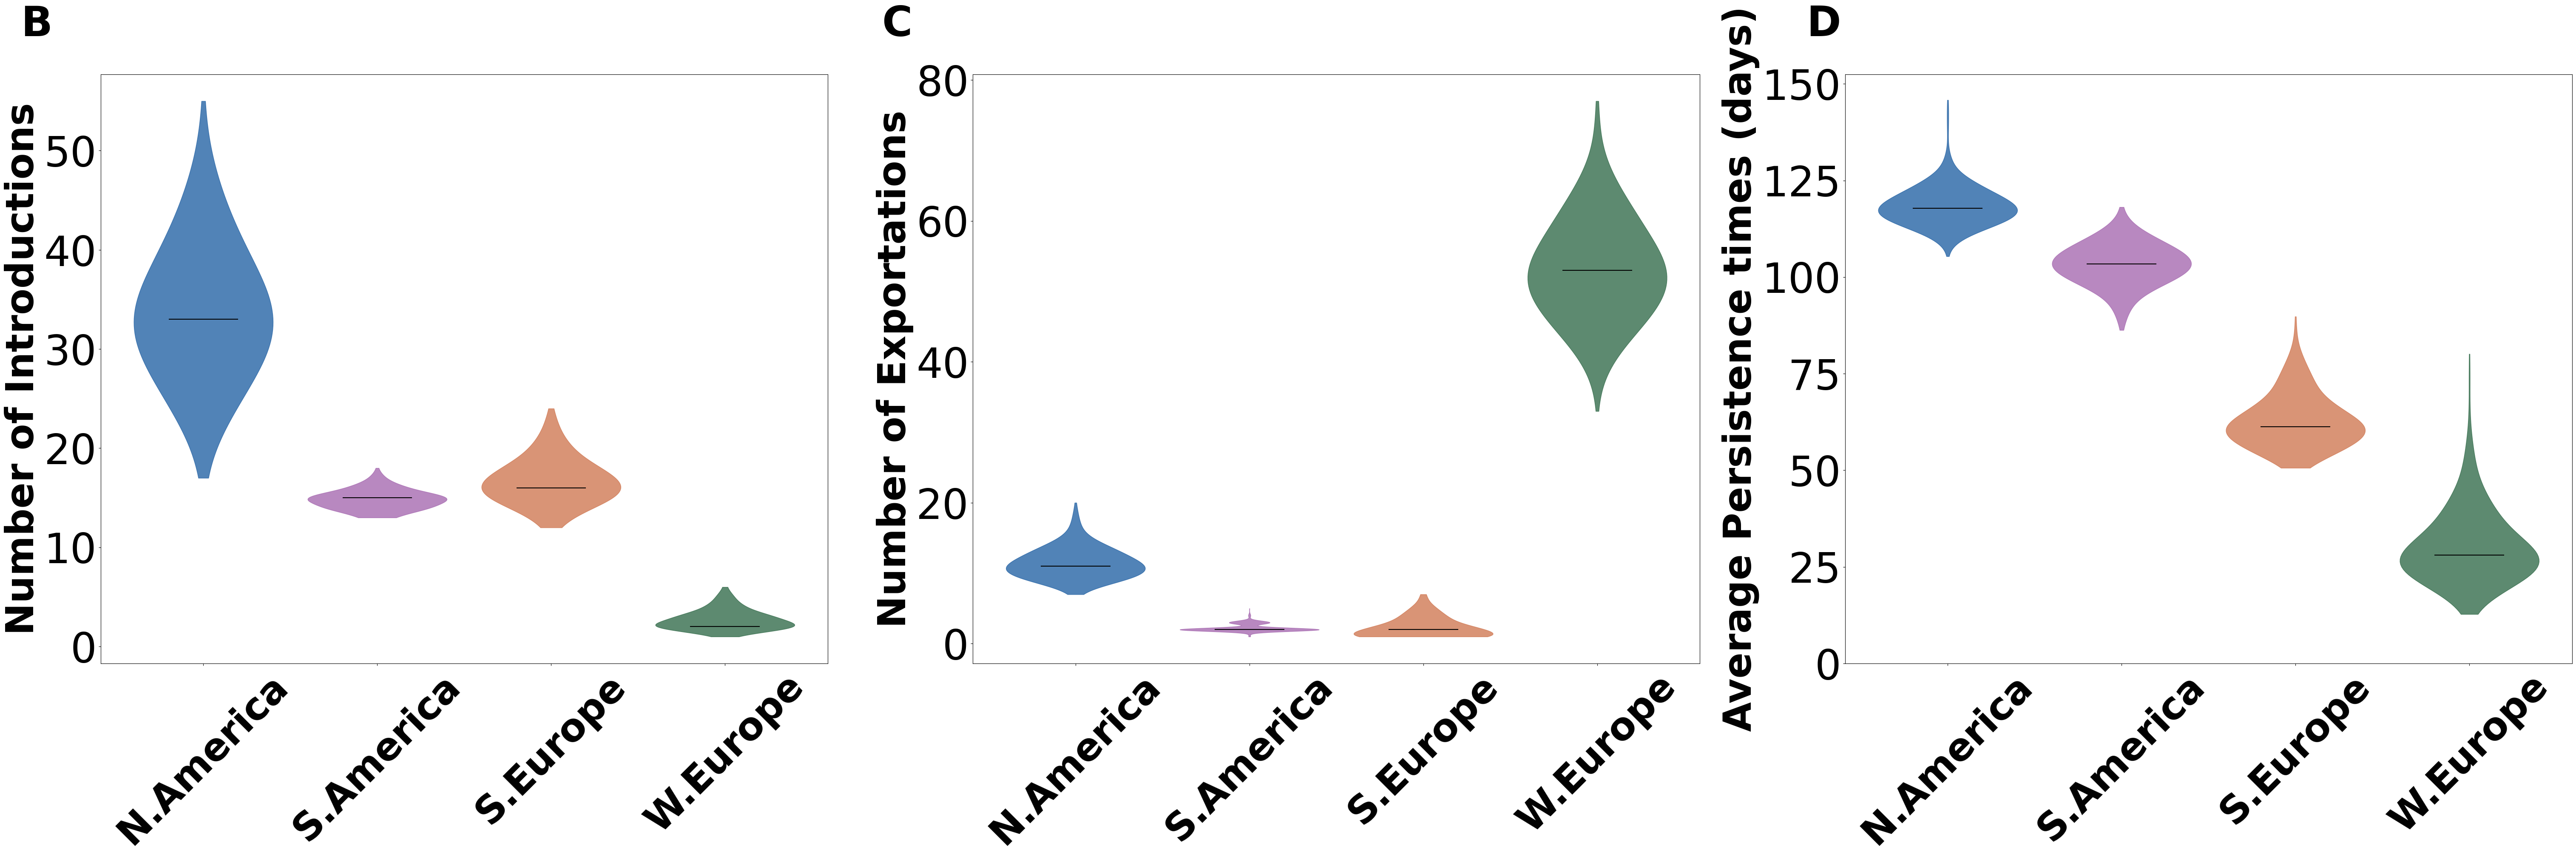

In [46]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(75, 18), facecolor='w')
#fig.suptitle('Publication Style Lettering', fontsize=30, fontweight='bold', x=0.05, y=1.05)
region_list = ["C.Europe", "N.America", "S.America", "S.Europe", "W.Europe"]

# First plot
pos = []
for index, place in enumerate(mig_dict_imports.keys()):


    violin_plot = axs[0].violinplot(mig_dict_imports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.6, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_imports.keys())
axs[0].set_xticks(pos)
axs[0].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[0].set_ylabel("Number of Introductions", fontsize=65, fontweight='bold')
axs[0].tick_params(axis='y', labelsize=70)

# Second plot
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    print(place, np.quantile(mig_dict_exports[place], 0.25))
    print( place, np.quantile(mig_dict_exports[place], 0.5))
    print(place, np.quantile(mig_dict_exports[place], 0.75))
    violin_plot = axs[1].violinplot(mig_dict_exports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_exports.keys())
axs[1].set_xticks(pos)
axs[1].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[1].set_ylabel("Number of Exportations", fontsize=65, fontweight='bold')
axs[1].tick_params(axis='y', labelsize=70)

# Third plot
pos = []
for index, place in enumerate(persist_dict.keys()):
    print(place, np.quantile(persist_dict[place], 0.25))
    print(place, np.quantile(persist_dict[place], 0.5))
    print(place, np.quantile(persist_dict[place], 0.75))
    violin_plot = axs[2].violinplot(persist_dict[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

countries = list(persist_dict.keys())
axs[2].set_xticks(pos)
axs[2].set_xticklabels(region_list, fontsize=65,rotation=45, fontweight='bold')
axs[2].set_ylabel("Average Persistence times (days)", fontsize=65, fontweight='bold')
axs[2].tick_params(axis='y', labelsize=70)
axs[2].set_ylim(bottom=0)


# Add publication style lettering in the upper left corner
fig.text(0.1, 0.93, "B", fontsize=70, fontweight='bold')
fig.text(0.37, 0.93, "C", fontsize=70, fontweight='bold')
fig.text(0.66, 0.93, "D", fontsize=70, fontweight='bold')

plt.savefig('../figures/1000_dta_region_combined_equal_temporal_sub.png', dpi=300, bbox_inches='tight')
plt.show()


## repeat for regional-based subsampling sensitivity analysis

In [10]:
trees =  "/Users/mparedes/Desktop/mpox_rhino/regional_analysis/regional_noCE_downsampled.trees"

In [11]:
all_trees = trees
burnin_percent = 0.5
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

937.0


In [12]:
migrations_df = run_mig_counts(all_trees, traitType = "region")

this took 139.4154658317566 seconds ( 2.3235910971959433  minutes) to run on 937 trees


In [13]:
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()

imports.index = imports.child_host
exports.index = exports.parent_host

#mig_dict = {}
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

In [14]:

colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

In [15]:
start_time = time.time()

with open(trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    persistence_dict = {}
    
    for line in infile:
       # print(line)
        if 'tree STATE_' in line:
            tree_counter += 1
            

            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                tree.setAbsoluteTime(2023.0068)
                trees_processed += 1

            # iterate through the tree and pull out all migration events
                persistence_dict[tree_counter] =  estimate_persistence(tree, "region")
            
# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
persistence_df = pd.DataFrame.from_dict({(i,j): persistence_dict[i][j] 
                           for i in persistence_dict.keys() 
                           for j in persistence_dict[i].keys()},
                       orient='index')

persistence_df
persistence_df.reset_index(inplace=True)
persistence_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
persistence_df.head(5)

this took 139.8649389743805 seconds ( 2.3310823162396748  minutes) to run on 937 trees


,tree_number,migration_event_number,type,migration date,tip date,persistance,tip_name,parent_host,child_host
0,938,1,WesternEurope-to-SouthernEurope,2022.535573,2022.623238,0.087665,Monkeypox/PT0501/2022_SouthernEurope_2022-08-16,WesternEurope,SouthernEurope
1,938,2,WesternEurope-to-NorthAmerica,2022.452883,2022.604060,0.151177,MPX/Human/USA/CA-LACPHL-MA00137/2022_NorthAmer...,WesternEurope,NorthAmerica
2,938,3,WesternEurope-to-NorthAmerica,2022.452883,2022.497211,0.044328,MPXV_USA_2022_CT0002_NorthAmerica_2022-07-01,WesternEurope,NorthAmerica
3,938,4,WesternEurope-to-SouthernEurope,2022.441973,2022.508170,0.066196,Monkeypox/PT0161/2022_SouthernEurope_2022-07-05,WesternEurope,SouthernEurope
4,938,5,WesternEurope-to-NorthAmerica,2022.413993,2022.546526,0.132533,MPX/Human/USA/CA-LACPHL-MA00192/2022_NorthAmer...,WesternEurope,NorthAmerica


In [16]:
persist = persistence_df.groupby(["child_host", "tree_number"])['persistance'].mean().reset_index()
persist['persistance'] = persist['persistance'].map(convert_persistence)
persist['persistance'] = persist['persistance'].div(86400) #calculating number of days from seconds
persist.index = persist.child_host


persist_dict={x:[] for x in persist["child_host"].unique()}

for items in persist.index.unique():
    persist_dict[items].append(persist.loc[items,"persistance"].values)
    


NorthAmerica 10.0
NorthAmerica 11.0
NorthAmerica 13.0
SouthAmerica 2.0
SouthAmerica 2.0
SouthAmerica 2.0
SouthernEurope 1.0
SouthernEurope 2.0
SouthernEurope 3.0
WesternEurope 48.0
WesternEurope 53.0
WesternEurope 58.0
NorthAmerica 115.0918865956713
NorthAmerica 117.82818947476852
NorthAmerica 121.04374966341435
SouthAmerica 99.84638893925926
SouthAmerica 103.3754734930324
SouthAmerica 106.71101455856481
SouthernEurope 58.010510196296295
SouthernEurope 61.29234966831019
SouthernEurope 66.23560505101852
WesternEurope 23.996254762974537
WesternEurope 28.03716553597222
WesternEurope 34.70013151266203


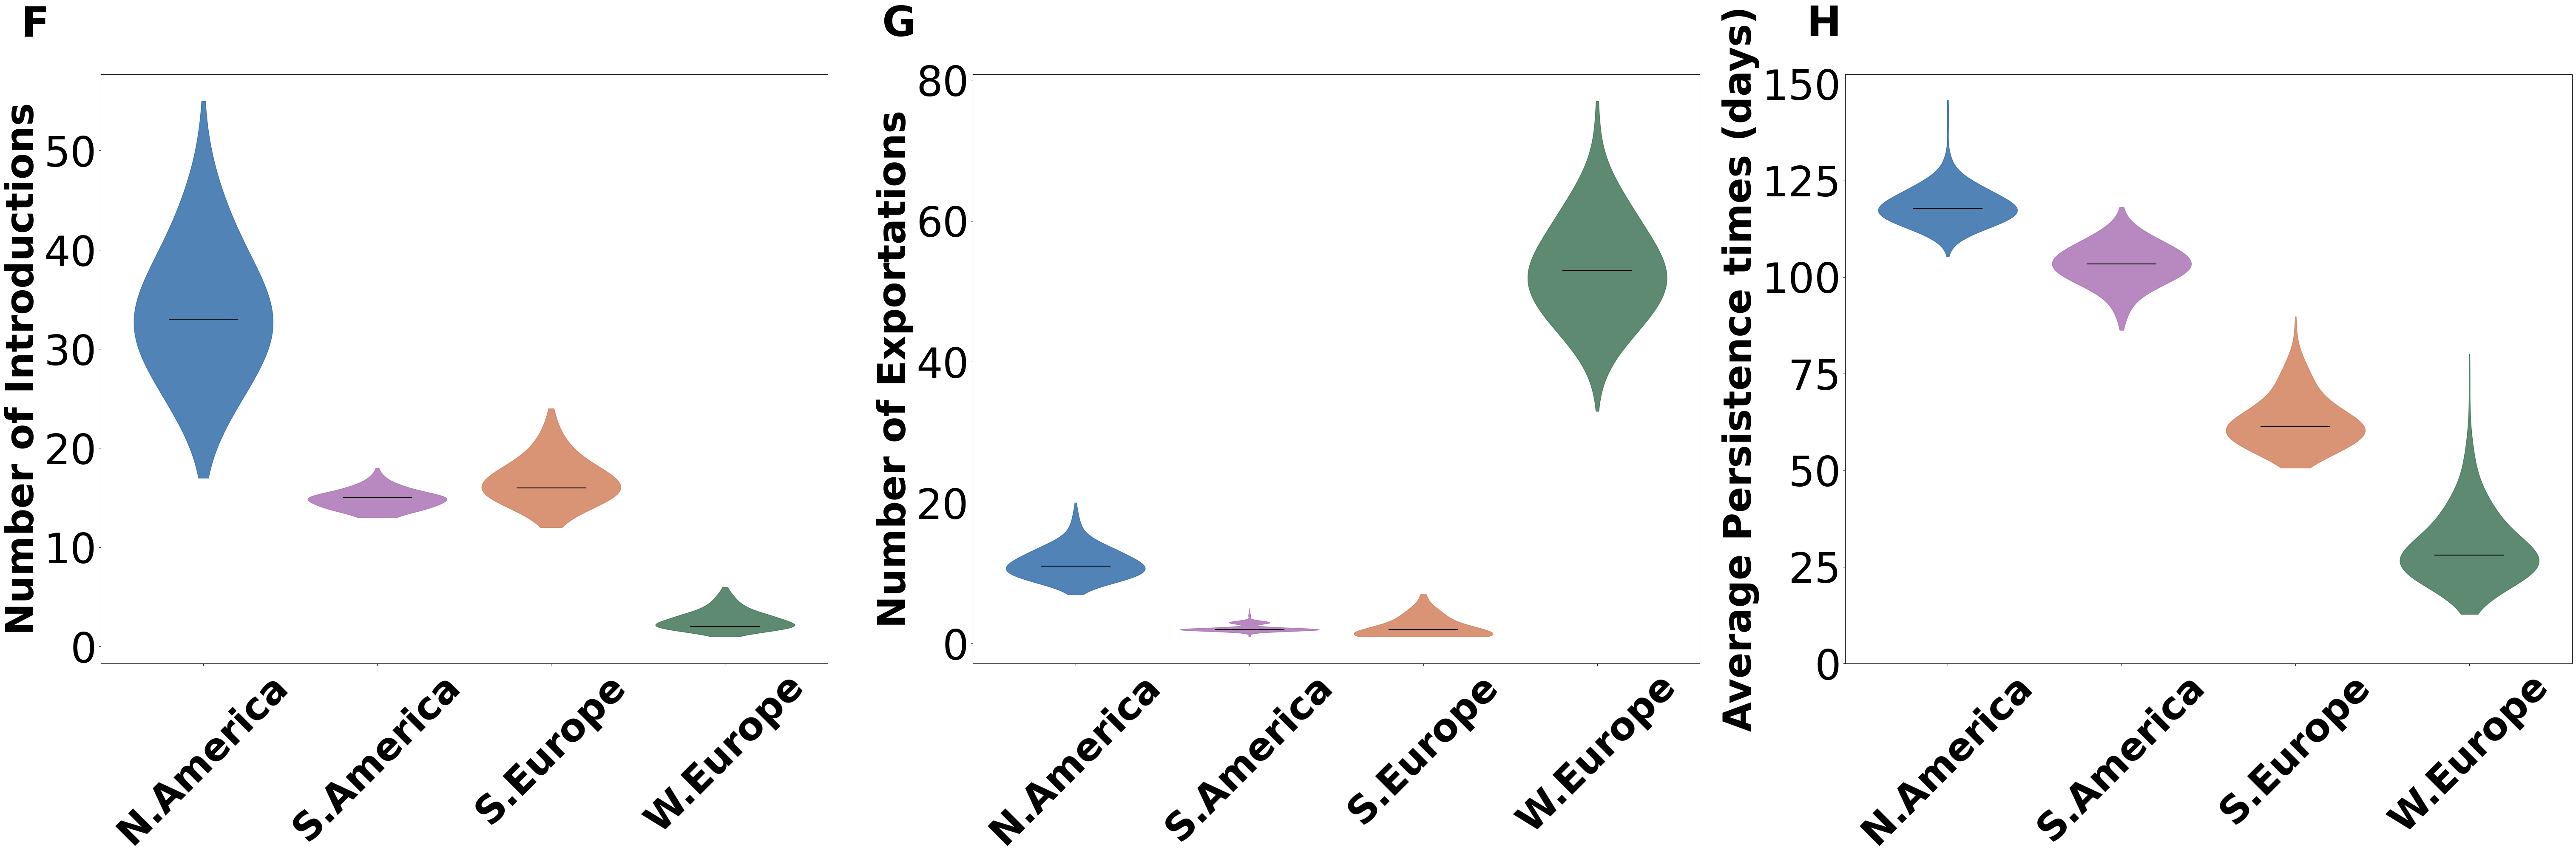

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(75, 18), facecolor='w')
#fig.suptitle('Publication Style Lettering', fontsize=30, fontweight='bold', x=0.05, y=1.05)
region_list = ["N.America", "S.America", "S.Europe", "W.Europe"]

# First plot
pos = []
for index, place in enumerate(mig_dict_imports.keys()):


    violin_plot = axs[0].violinplot(mig_dict_imports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.6, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_imports.keys())
axs[0].set_xticks(pos)
axs[0].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[0].set_ylabel("Number of Introductions", fontsize=65, fontweight='bold')
axs[0].tick_params(axis='y', labelsize=70)

# Second plot
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    print(place, np.quantile(mig_dict_exports[place], 0.25))
    print( place, np.quantile(mig_dict_exports[place], 0.5))
    print(place, np.quantile(mig_dict_exports[place], 0.75))
    violin_plot = axs[1].violinplot(mig_dict_exports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_exports.keys())
axs[1].set_xticks(pos)
axs[1].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[1].set_ylabel("Number of Exportations", fontsize=65, fontweight='bold')
axs[1].tick_params(axis='y', labelsize=70)

# Third plot
pos = []
for index, place in enumerate(persist_dict.keys()):
    print(place, np.quantile(persist_dict[place], 0.25))
    print(place, np.quantile(persist_dict[place], 0.5))
    print(place, np.quantile(persist_dict[place], 0.75))
    violin_plot = axs[2].violinplot(persist_dict[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

countries = list(persist_dict.keys())
axs[2].set_xticks(pos)
axs[2].set_xticklabels(region_list, fontsize=65,rotation=45, fontweight='bold')
axs[2].set_ylabel("Average Persistence times (days)", fontsize=65, fontweight='bold')
axs[2].tick_params(axis='y', labelsize=70)
axs[2].set_ylim(bottom=0)


# Add publication style lettering in the upper left corner
fig.text(0.1, 0.93, "F", fontsize=70, fontweight='bold')
fig.text(0.37, 0.93, "G", fontsize=70, fontweight='bold')
fig.text(0.66, 0.93, "H", fontsize=70, fontweight='bold')

plt.savefig('../figures/dta_regional_subsampling_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()
